In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd drive/My Drive/Univ Of Oulu/masters_thesis/preprocess_dataset

/content/drive/My Drive/Univ Of Oulu/masters_thesis/preprocess_dataset


In [3]:
!pip install transformers
!pip install bert-for-tf2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.2 MB 32.4 MB/s 
     |████████████████████████████████| 84 kB 2.9 MB/s 
     |████████████████████████████████| 6.6 MB 66.1 MB/s 
     |████████████████████████████████| 596 kB 48.6 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 41 kB 170 kB/s 
  Created wheel for bert-for-tf2: filename=bert_for_tf2-0.14.9-py3-none-any.whl size=30535 sha256=c48028e9aa2f1e6ab0f3fa638d048cc9b76794b1ed3286ec9226956e5c83ad3d
  Stored in directory: /root/.cache/pip/wheels/47/b6/e5/8c76ec779f54bc5c2f1b57d2200bb9c77616da83873e8acb53
  Created wheel for params-flow: filename=params_flow-0.8.2-py3-none-any.whl size=19472 sha256=59

In [4]:
import torch
print('\nLoading model to GPU...')
device = torch.device('cuda')


Loading model to GPU...


In [5]:
import pandas as pd
data = pd.read_csv("datasets/preparation_of_datasets/Amazon_Music/new_vader/Preprocessed_Amazon_Music_dataset.csv", sep=",", header=0)
data_text = data["reviews"]

In [6]:
data.head(3)

,user,item,label,reviews,vader_negations,vader_sentiment_score
0,1,1,5,"It's hard to believe ""Memory of Trees"" came ou...",0,0.4333
1,2,1,5,"A clasically-styled and introverted album, Mem...",1,0.3591
2,3,1,5,I never thought Enya would reach the sublime h...,0,0.5226


In [7]:
data.shape

(64705, 6)

In [8]:
from transformers import BertTokenizer

# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Loading BERT tokenizer...


Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [9]:
use_fixed_padding = True

if use_fixed_padding:
    batch_size = 16
    max_len = 400

    # Tokenize all training examples
    print('Tokenizing {:,} training samples...'.format(len(data_text)))

    batches_input_ids = []
    batches_attention_masks = []
    embeddings = []
    update_interval = batch_size * 150
    for i in range(0, len(data_text), batch_size):
        # Report progress.
        if ((i % update_interval) == 0):
            print('  Tokenized {:,} samples.'.format(i))
        # `encode_plus` will:
        #   (1) Tokenize the sentence.
        #   (2) Prepend the `[CLS]` token to the start.
        #   (3) Append the `[SEP]` token to the end.
        #   (4) Map tokens to their IDs.
        #   (5) Pad or truncate the sentence to `max_length`
        #   (6) Create attention masks for [PAD] tokens.
        encoded_dict = tokenizer.batch_encode_plus(
            data_text[i:i + batch_size],  # Batch of sentences to encode.
            add_special_tokens=True,  # Add '[CLS]' and '[SEP]'
            max_length=max_len,  # Pad & truncate all sentences.
            padding='max_length',  # Pad all to the `max_length` parameter.
            truncation=True,
            return_attention_mask=True,  # Construct attn. masks.
            return_tensors='pt',  # Return pytorch tensors.
        )
        # Add the encoded sentence to the list.
        batches_input_ids.append(encoded_dict['input_ids'])

        # And its attention mask (simply differentiates padding from non-padding).
        batches_attention_masks.append(encoded_dict['attention_mask'])

Tokenizing 64,705 training samples...
  Tokenized 0 samples.
  Tokenized 2,400 samples.
  Tokenized 4,800 samples.
  Tokenized 7,200 samples.
  Tokenized 9,600 samples.
  Tokenized 12,000 samples.
  Tokenized 14,400 samples.
  Tokenized 16,800 samples.
  Tokenized 19,200 samples.
  Tokenized 21,600 samples.
  Tokenized 24,000 samples.
  Tokenized 26,400 samples.
  Tokenized 28,800 samples.
  Tokenized 31,200 samples.
  Tokenized 33,600 samples.
  Tokenized 36,000 samples.
  Tokenized 38,400 samples.
  Tokenized 40,800 samples.
  Tokenized 43,200 samples.
  Tokenized 45,600 samples.
  Tokenized 48,000 samples.
  Tokenized 50,400 samples.
  Tokenized 52,800 samples.
  Tokenized 55,200 samples.
  Tokenized 57,600 samples.
  Tokenized 60,000 samples.
  Tokenized 62,400 samples.


In [10]:
# import tensorflow as tf
# bert = TFBertModel.from_pretrained('bert-base-uncased')

# # For each batch of training data...
# for step in range(0, len(batches_input_ids)):
#     b_input_ids = batches_input_ids[step]
#     b_input_masks = batches_attention_masks[step]

#     input_ids = tf.keras.layers.Input(shape=(400,), name='b_input_ids', dtype='int32')
#     mask = tf.keras.layers.Input(shape=(400,), name='b_input_masks', dtype='int32')

#     embeddings.append(bert(input_ids, attention_mask=mask)[1])
#     # print(bert(input_ids, attention_mask=mask)[1].shape)
# print(len(embeddings))

In [11]:
from transformers import BertModel
bert = BertModel.from_pretrained('bert-base-uncased')
desc = bert.to(device)

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [12]:
results = []
# For each batch of training data...
for step in range(0, len(batches_input_ids)):

    # Copy the current training batch to the GPU using the `to` method.
    b_input_ids = batches_input_ids[step].to(device)
    b_input_mask = batches_attention_masks[step].to(device)
    
    with torch.no_grad():
          outputs = bert(b_input_ids, attention_mask=b_input_mask)
    results.append(outputs[1])

In [13]:
print(len(results))
print(results[0].shape)
print(results[0][15].shape)

4045
torch.Size([16, 768])
torch.Size([768])


In [14]:
emb = []
for i in range(len(results)):
  for j in range(len(results[i])):
    emb.append(results[i][j])
print(len(emb))

64705


In [15]:
# my_df = pd.DataFrame(emb)
# # my_df.to_csv('bert_emb', index=False)

#### BERT embeddings dimensionality reduction using PCA

In [16]:
import numpy as np
from sklearn.decomposition import PCA

embs = [e.cpu().detach().numpy() for e in emb]

In [17]:
data_len = len(data)
bert_embs = np.array(embs)
print("bert_embs.shape: ", bert_embs.shape)

bert_embs.shape:  (64705, 768)


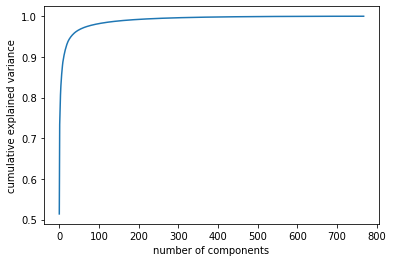

In [18]:
pca1 = PCA().fit(bert_embs)
import matplotlib.pyplot as plt
plt.plot(np.cumsum(pca1.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

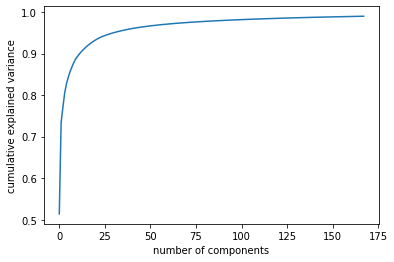

In [19]:
pca2 = PCA(0.99)
bbb = pca2.fit_transform(bert_embs)
plt.plot(np.cumsum(pca2.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

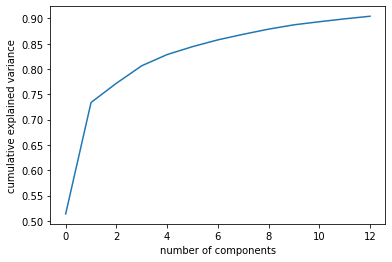

In [20]:
pca = PCA(0.90)
bbb = pca.fit_transform(bert_embs)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

In [21]:
n_comp = pca.n_components_
print(n_comp)
pca = PCA(n_components=n_comp)
bert_emb_pca = pca.fit_transform(bert_embs)
print("bert_emb_pca.shape: ", bert_emb_pca.shape)

13
bert_emb_pca.shape:  (64705, 13)


In [22]:
print(pca.explained_variance_)

[12.772707    5.467198    0.9433284   0.85955864  0.5489553   0.38817778
  0.3329591   0.27379552  0.25252992  0.21222025  0.15107313  0.141998
  0.12778446]


In [23]:
# my_df = pd.DataFrame(bert_emb_pca, columns=['review_emb1','review_emb2','review_emb3','review_emb4', 'review_emb5', 'review_emb6'])
# my_df.to_csv('bert_embs.csv', index=False)

In [24]:
# data['review_emb1'] = bert_emb_pca[:,0]
# data['review_emb2'] = bert_emb_pca[:,1]
# data['review_emb3'] = bert_emb_pca[:,2]
# data['review_emb4'] = bert_emb_pca[:,3]
# data['review_emb5'] = bert_emb_pca[:,4]
# data['review_emb6'] = bert_emb_pca[:,5]


for i in range(n_comp):
    col_val = 'review_emb{}'.format(i+1)
    data[col_val] = bert_emb_pca[:,i]

In [25]:
data.head(2)

,user,item,label,reviews,vader_negations,vader_sentiment_score,review_emb1,review_emb2,review_emb3,review_emb4,review_emb5,review_emb6,review_emb7,review_emb8,review_emb9,review_emb10,review_emb11,review_emb12,review_emb13
0,1,1,5,"It's hard to believe ""Memory of Trees"" came ou...",0,0.4333,-0.611239,-1.837591,-0.405854,-0.366546,0.254673,0.863877,0.490165,0.533218,-0.504906,-0.174855,0.204785,-0.042151,0.140633
1,2,1,5,"A clasically-styled and introverted album, Mem...",1,0.3591,-4.554770,0.934950,-0.298552,-0.206955,0.945073,-0.235875,-0.052247,0.342730,-0.148117,-0.269378,0.097177,0.204526,-0.589852


In [26]:
data.to_csv("datasets/preparation_of_datasets/Amazon_Music/new_vader/bert_emb_pca{}_senti.csv".format(n_comp), index=False)